In [17]:
#%pip install tensorflow

import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix

In [19]:
train_data_dir = os.path.join('train')
valid_data_dir = os.path.join('val')
test_data_dir = os.path.join('test')

batchSize = 32
size = 256
img_size = (size, size)

train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    label_mode = "categorical",
    batch_size=batchSize,
    image_size = img_size
)

number_of_classes = len(train_data.class_names)
class_names= train_data.class_names


valid_data = tf.keras.utils.image_dataset_from_directory(
    valid_data_dir,
    label_mode = "categorical",
    batch_size=batchSize,
    image_size = img_size
)


test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    label_mode = "categorical",
    batch_size=batchSize,
    image_size = img_size
)

Found 2503 files belonging to 6 classes.
Found 503 files belonging to 6 classes.
Found 503 files belonging to 6 classes.


In [21]:
print(number_of_classes)
print(class_names)

6
['Asian-Green-Bee-Eater', 'Coppersmith-Barbet', 'Jungle-Babbler', 'No Bird Detected', 'Red-Wattled-Lapwing', 'White-Breasted-Kingfisher']


In [22]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast, RandomTranslation

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomFlip("vertical"),
  RandomRotation(0.7),
  RandomZoom(0.25),  
  RandomBrightness(0.1),
  RandomContrast(0.1)
])

train_data = train_data.map(lambda x, y: (data_augmentation(x), y))

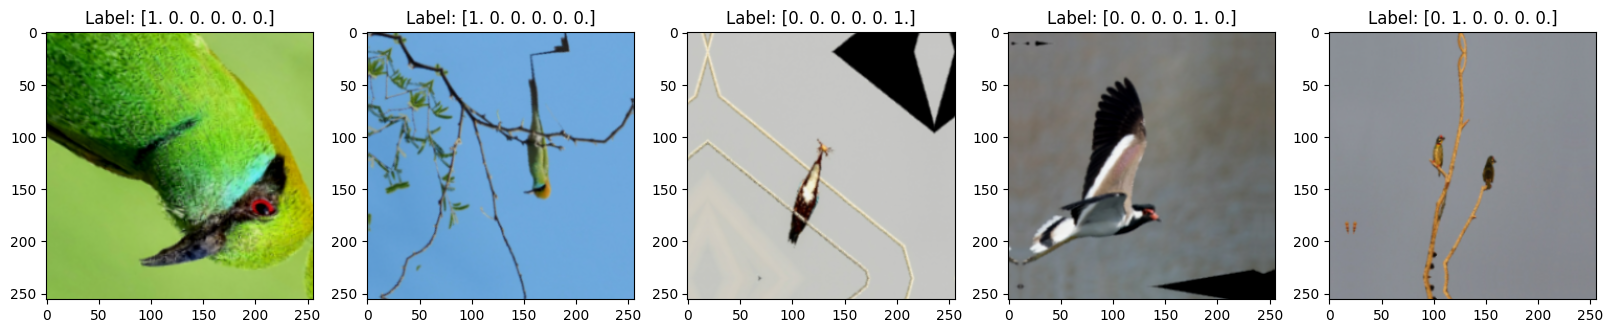

In [23]:
# Visualize augmented images
batch = next(train_data.as_numpy_iterator())  # Get a batch
images, labels = batch
augmented_images = data_augmentation(images)
augmented_images = augmented_images.numpy() / 255.0 # Normalize for visualization

fig, axs = plt.subplots(ncols=5, figsize=(20, 20))
for index, image in enumerate(augmented_images[0:5]):
  axs[index].imshow(image)
  axs[index].title.set_text(f"Label: {labels[index]}")
plt.show()

In [24]:
train_data.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))

In [26]:
lambd = 0.0005 
convDropout = 0.3
model = Sequential()

# ✅ Definir la entrada aquí
model.add(Input(shape=(size, size, 3)))

# First convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(lambd)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(lambd)))  
model.add(BatchNormalization())  
model.add(MaxPooling2D((2, 2)))

# Second convolutional block
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(lambd)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(lambd)))
model.add(Dropout(convDropout))
model.add(MaxPooling2D((2, 2)))

# Third convolutional block
model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(lambd)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(lambd)))
model.add(Dropout(convDropout))
model.add(MaxPooling2D((2, 2)))

# Dense layers
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(lambd)))
model.add(Dropout(convDropout))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(lambd)))
model.add(Dropout(convDropout))
model.add(Dense(256, activation='relu'))
model.add(Dense(number_of_classes, activation='softmax'))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,833,606 (10.81 MB)

 Trainable params: 2,833,478 (10.81 MB)

 Non-trainable params: 128 (512.00 B)

In [27]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=7)  
tensorboard_callback = TensorBoard(log_dir='logs')

checkpoint = "checkpoint_model.keras"
model_checkpoint = ModelCheckpoint(filepath=checkpoint, monitor='val_categorical_accuracy', save_best_only=True)

def scheduler(epoch, lr):
    if epoch < 14:
        return lr
    elif epoch > 12 and epoch <= 18:
        return 0.0005
    else:
        return 0.0001

lr_scheduler = LearningRateScheduler(scheduler)

hist = model.fit(
    train_data,
    epochs=25, # estaban 50 epochas, lo puse a la mitad
    validation_data=valid_data,
    callbacks=[early_stopping, tensorboard_callback, model_checkpoint, lr_scheduler]
)
# lambda = 0.0001
# learning rate = 0.0001
# convDropout = 0.3

Epoch 1/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - categorical_accuracy: 0.3096 - loss: 2.6102 - val_categorical_accuracy: 0.4751 - val_loss: 2.1819 - learning_rate: 0.0010
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - categorical_accuracy: 0.4754 - loss: 2.0429 - val_categorical_accuracy: 0.4732 - val_loss: 1.8835 - learning_rate: 0.0010
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - categorical_accuracy: 0.5569 - loss: 1.7718 - val_categorical_accuracy: 0.6083 - val_loss: 1.6409 - learning_rate: 0.0010
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - categorical_accuracy: 0.6408 - loss: 1.5728 - val_categorical_accuracy: 0.5646 - val_loss: 1.7060 - learning_rate: 0.0010
Epoch 5/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - categorical_accuracy: 0.6472 - loss: 1.5035 - val_categorical_accuracy: 0.6123 - val_loss: 1.5380 - learning_rate: 0.0010
Epoch 6/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - categorical_accuracy: 0.7167 - loss: 1.2807 - val_categorical_accuracy: 0.7416

In [28]:
test_loss, test_acc = model.evaluate(test_data)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - categorical_accuracy: 0.9344 - loss: 0.4488
Test accuracy: 0.9343936443328857
Test loss: 0.44879963994026184


In [29]:
test_data.class_names

['Asian-Green-Bee-Eater',
 'Coppersmith-Barbet',
 'Jungle-Babbler',
 'No Bird Detected',
 'Red-Wattled-Lapwing',
 'White-Breasted-Kingfisher']

In [30]:
pre = Precision()
re = Recall()

for batch in test_data.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)

print('Precision:', pre.result().numpy())
print('Recall:', re.result().numpy())
print('Accuracy:', np.mean(hist.history['categorical_accuracy']))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Precision: 0.9510204
Recall: 0.9264414
Accuracy: 0.7902037537097931


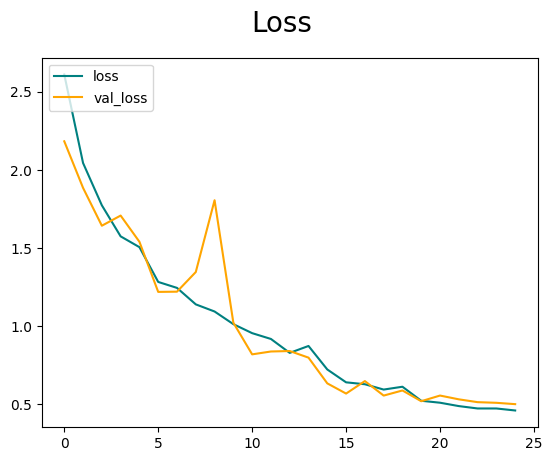

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

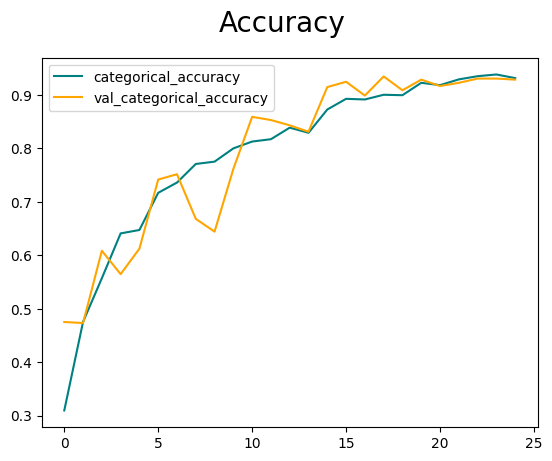

In [32]:
fig = plt.figure()
plt.plot(hist.history['categorical_accuracy'], color='teal', label='categorical_accuracy')
plt.plot(hist.history['val_categorical_accuracy'], color='orange', label='val_categorical_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [33]:
os.makedirs('models', exist_ok=True)
model.save(os.path.join('models','birdclassifier95_3.keras'))

In [14]:
# def find_duplicate_images(folder_path):
#   duplicates = {}
#   for filename in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, filename)
#     if os.path.isfile(file_path):
#       # Read the image file in binary mode
#       with open(file_path, 'rb') as f:
#         # Generate SHA-1 hash of the image content
#         image_hash = hashlib.sha1(f.read()).hexdigest()
#       if image_hash in duplicates:
#         duplicates[image_hash].append(file_path)
#       else:
#         duplicates[image_hash] = [file_path]
#   return duplicates

# def remove_duplicates(duplicates):
#   for image_hash, files in duplicates.items():
#     if len(files) > 1:
#       # Remove all duplicate files except the first one (assumed original)
#       for file in files[1:]:
#         os.remove(file)
#         print(f"Deleted duplicate: {file}")

# if __name__ == "__main__":
#   folder_path = "train/Rock Pigeon"  # Replace with your actual folder path
#   duplicates = find_duplicate_images(folder_path)
#   remove_duplicates(duplicates)  # Automatic deletion, confirmation set to False by default
